## This notebook's goals:

Try out hyperband tuning while all the categorical data is one-hot encoded (i.e. no features engineering as before) and see if there's an improvement with synthetic data

The following was performed here:
- 1h encoding of the features (unlike before, where some feature engineering took place)
- Hyperband tuning on both imbalanced and synthesized data with the goal to improve model recall


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

raw_data = pd.read_csv('BankChurners.csv', index_col = 0)
raw_data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
CLIENTNUM,,,,,,,,,,,,,,,,,,,,,
768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [2]:
#map targets and put them aside
raw_data['Attrition_Flag'] = raw_data['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})
y = raw_data.pop('Attrition_Flag')

In [3]:
raw_data.columns

Index(['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level',
       'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

In [4]:
raw_data.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
              'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'
              ],axis = 1, inplace = True)

In [5]:
raw_data['Gender'] =raw_data['Gender'].map({'M':0, 'F': 1})

This time I'll leave out deleting potential multicollinear features

In [6]:
cp = raw_data.copy()

In [7]:
cat_f = ['Education_Level','Marital_Status','Income_Category','Card_Category']

cp = pd.get_dummies(cp, columns = cat_f)

In [8]:
cp.columns

Index(['Customer_Age', 'Gender', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Education_Level_College', 'Education_Level_Doctorate',
       'Education_Level_Graduate', 'Education_Level_High School',
       'Education_Level_Post-Graduate', 'Education_Level_Uneducated',
       'Education_Level_Unknown', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Unknown', 'Income_Category_$120K +',
       'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K',
       'Income_Category_$80K - $120K', 'Income_Category_Less than $40K',
       'Income_Category_Unknown', 'Card_Category_Blue', 'Card_Category_Gold',
       'Card_Category_Platinum', 'Card_Category_Silver'],


Note: SMOTE is theoretically less effective in sparse spaces

In [9]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [10]:
sclr = RobustScaler()

X_train, X_test, y_train, y_test = train_test_split(cp, y, test_size = 1000)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 1000)

X_train = sclr.fit_transform(X_train)
X_valid = sclr.transform(X_valid)
X_test = sclr.transform(X_test)

### Hyperband non-SMOTE

In [11]:
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt

In [12]:
def model_builder(hp):
    model = keras.Sequential()
    
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
    
    hp_units1 = hp.Int('units1', min_value = 32, max_value = 512, step = 32)
    model.add(keras.layers.Dense(units = hp_units1, activation = 'relu'))
    
    model.add(keras.layers.Dense(1, activation = 'sigmoid')) #logit
    
    hp_lr = hp.Choice('learning_rate', values = [1e-2, 3e-3, 1e-3, 5e-4, 1e-4])
    
    adam = keras.optimizers.Adam(learning_rate = hp_lr)
    
    recall = keras.metrics.Recall()
    auc = keras.metrics.AUC()
    
    model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = [recall, auc])
    
    return model

let's focus on recall again just to have the comparison...

In [13]:
tuner = kt.Hyperband(model_builder, objective = kt.Objective("val_recall", direction="max"),
                     max_epochs = 50, factor = 3, directory = 'kt_1h', project_name = 'kt_0')

In [14]:
import IPython
class ClearTrainingOutput(keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait=True)

In [15]:
tuner.search(X_train, y_train, epochs = 100, validation_data = (X_valid, y_valid), callbacks = [ClearTrainingOutput()])

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}, the optimal number of units in the second densely-connected layer
is {best_hps.get('units1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 90 Complete [00h 00m 16s]
val_recall: 0.800000011920929

Best val_recall So Far: 0.9090909361839294
Total elapsed time: 00h 07m 37s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 160, the optimal number of units in the second densely-connected layer
is 416 and the optimal learning rate for the optimizer
is 0.003.



In [16]:
def train_model(lr, units, units1, epochs, X = X_train, y = y_train, Xv = X_valid, yv = y_valid):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = units, activation = 'relu'))
    model.add(keras.layers.Dense(units = units1, activation = 'relu'))
    model.add(keras.layers.Dense(1, activation = 'sigmoid'))
    adam = keras.optimizers.Adam(learning_rate = lr)
    recall = keras.metrics.Recall()
    auc = keras.metrics.AUC()
    model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = [recall, auc])
    ES = keras.callbacks.EarlyStopping(monitor = 'val_recall_1', restore_best_weights = True, patience = 3, mode = 'max')
    history = model.fit(X, y, epochs = epochs, validation_data = (Xv, yv), callbacks = [ES])
    
    plt.plot(history.history['val_recall_1'], 'r', label = 'val_recall')
    plt.legend()
    plt.title('Training loss and recall')
    plt.show()
    
    return model

Epoch 1/50
254/254 [==============================] - 1s 2ms/step - loss: 0.2424 - recall_1: 0.5795 - auc_1: 0.9172 - val_loss: 0.1954 - val_recall_1: 0.6000 - val_auc_1: 0.9532
Epoch 2/50
254/254 [==============================] - 0s 1ms/step - loss: 0.1738 - recall_1: 0.7052 - auc_1: 0.9615 - val_loss: 0.1906 - val_recall_1: 0.7212 - val_auc_1: 0.9546
Epoch 3/50
254/254 [==============================] - 0s 1ms/step - loss: 0.1474 - recall_1: 0.7662 - auc_1: 0.9726 - val_loss: 0.1715 - val_recall_1: 0.7212 - val_auc_1: 0.9664
Epoch 4/50
254/254 [==============================] - 0s 1ms/step - loss: 0.1255 - recall_1: 0.8017 - auc_1: 0.9807 - val_loss: 0.1663 - val_recall_1: 0.8121 - val_auc_1: 0.9678
Epoch 5/50
254/254 [==============================] - 0s 1ms/step - loss: 0.1117 - recall_1: 0.8318 - auc_1: 0.9846 - val_loss: 0.1514 - val_recall_1: 0.8667 - val_auc_1: 0.9723
Epoch 6/50
254/254 [==============================] - 0s 1ms/step - loss: 0.0953 - recall_1: 0.8549 - auc_1: 0

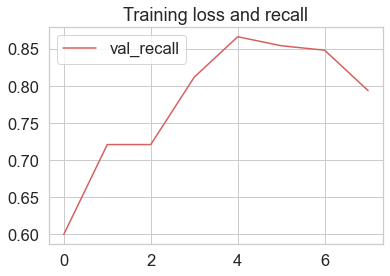

In [17]:
model_1 = train_model(lr = 0.003, units = 160, units1 = 416, epochs = 50)

In [18]:
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap = 'Greens')
    plt.title('Confusion matrix at probability: {:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    print('No churn detected (True Negatives): ', cm[0][0])
    print('Churn Incorrectly Detected (False Positives): ', cm[0][1])
    print('Churn Missed (False Negatives): ', cm[1][0])
    print('Churn Detected (True Positives): ', cm[1][1])
    print('Total Churns: ', np.sum(cm[1]))
    
    print('Model precision: ', cm[1][1]/(cm[1][1]+cm[0][1]))
    print('Model recall: ', cm[1][1]/(cm[1][1]+cm[1][0]))
    print('Model accuracy: ', (cm[1][1]+cm[0][0])/len(labels))

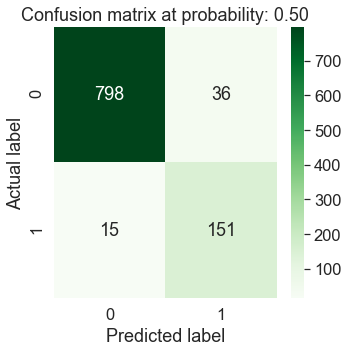

No churn detected (True Negatives):  798
Churn Incorrectly Detected (False Positives):  36
Churn Missed (False Negatives):  15
Churn Detected (True Positives):  151
Total Churns:  166
Model precision:  0.8074866310160428
Model recall:  0.9096385542168675
Model accuracy:  0.949


In [19]:
y_pred_1 = model_1.predict(X_test)
plot_cm(y_test, y_pred_1)

One-hot encoded features apparently indeed improve the performance of the neural network. What about synthesized data?

### Hyperband with SMOTE data

In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

over = SMOTE(sampling_strategy = 0.5, random_state = 42)
under = RandomUnderSampler(sampling_strategy = 1, random_state = 42)
seq = [('over',over),('under',under)]
pipeline = Pipeline(steps=seq)

X_train_bal, y_train_bal = pipeline.fit_resample(X_train, y_train)
X_valid_bal, y_valid_bal = pipeline.fit_resample(X_valid, y_valid)

print('Training size:',len(X_train_bal))
print('Train positives', Counter(y_train_bal)[1])
print('Valid size:', len(X_valid_bal))
print('Valid positives', Counter(y_valid_bal)[1])

Training size: 6830
Train positives 3415
Valid size: 834
Valid positives 417


In [21]:
tuner = kt.Hyperband(model_builder, objective = kt.Objective("val_recall", direction="max"),
                     max_epochs = 50, factor = 3, directory = 'kt_1h', project_name = 'kt_bal_1')

In [22]:
tuner.search(X_train_bal, y_train_bal, epochs = 100, validation_data = (X_valid_bal, y_valid_bal), callbacks = [ClearTrainingOutput()])

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}, the optimal number of units in the second densely-connected layer
is {best_hps.get('units1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 90 Complete [00h 00m 20s]
val_recall: 0.9496402740478516

Best val_recall So Far: 0.9616307020187378
Total elapsed time: 00h 07m 00s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 288, the optimal number of units in the second densely-connected layer
is 480 and the optimal learning rate for the optimizer
is 0.003.



Model with synthesized data scored even higher validation recall. Is this really an improvement though?

In [23]:
def train_model_bal(lr, units, units1, epochs, X = X_train_bal, y = y_train_bal, Xv = X_valid_bal, yv = y_valid_bal):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = units, activation = 'relu'))
    model.add(keras.layers.Dense(units = units1, activation = 'relu'))
    model.add(keras.layers.Dense(1, activation = 'sigmoid'))
    adam = keras.optimizers.Adam(learning_rate = lr)
    recall = keras.metrics.Recall()
    auc = keras.metrics.AUC()
    model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = [recall, auc])
    ES = keras.callbacks.EarlyStopping(monitor = 'val_recall_1', restore_best_weights = True, patience = 3, mode = 'max')
    history = model.fit(X, y, epochs = epochs, validation_data = (Xv, yv), callbacks = [ES])
    
    plt.plot(history.history['val_recall_1'], 'r', label = 'val_recall')
    plt.legend()
    plt.title('Training loss and recall')
    plt.show()
    
    return model

Epoch 1/50
214/214 [==============================] - 1s 4ms/step - loss: 0.2880 - recall_1: 0.8914 - auc_1: 0.9486 - val_loss: 0.2517 - val_recall_1: 0.8969 - val_auc_1: 0.9614
Epoch 2/50
214/214 [==============================] - 0s 2ms/step - loss: 0.1847 - recall_1: 0.9391 - auc_1: 0.9785 - val_loss: 0.2537 - val_recall_1: 0.8657 - val_auc_1: 0.9620
Epoch 3/50
214/214 [==============================] - 0s 2ms/step - loss: 0.1448 - recall_1: 0.9552 - auc_1: 0.9860 - val_loss: 0.2590 - val_recall_1: 0.9400 - val_auc_1: 0.9667
Epoch 4/50
214/214 [==============================] - 0s 2ms/step - loss: 0.1245 - recall_1: 0.9616 - auc_1: 0.9891 - val_loss: 0.2427 - val_recall_1: 0.9089 - val_auc_1: 0.9695
Epoch 5/50
214/214 [==============================] - 0s 2ms/step - loss: 0.0880 - recall_1: 0.9745 - auc_1: 0.9944 - val_loss: 0.2665 - val_recall_1: 0.9281 - val_auc_1: 0.9687
Epoch 6/50
214/214 [==============================] - 0s 2ms/step - loss: 0.0829 - recall_1: 0.9772 - auc_1: 0

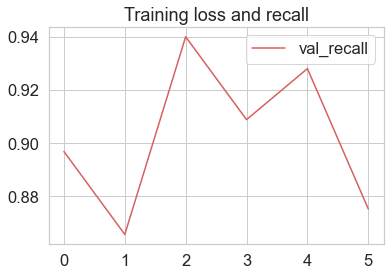

In [24]:
model_bal_1 = train_model_bal(lr = 0.003, units = 288, units1 = 480, epochs = 50)

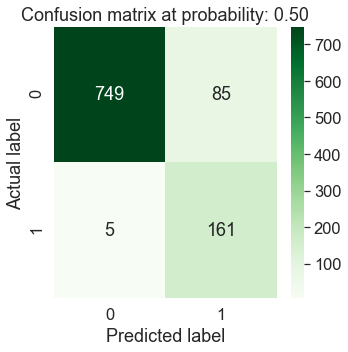

No churn detected (True Negatives):  749
Churn Incorrectly Detected (False Positives):  85
Churn Missed (False Negatives):  5
Churn Detected (True Positives):  161
Total Churns:  166
Model precision:  0.6544715447154471
Model recall:  0.9698795180722891
Model accuracy:  0.91


In [25]:
y_pred_bal_1 = model_bal_1.predict(X_test)
plot_cm(y_test, y_pred_bal_1)

### Brief commentary on this try
So this model really pushed the recall quite high! And just as with the previous tries, the synthesized data allowed the recall to rise while trading off the precision, which now is quite low, but still acceptable. Overall accuracy has gone down, now it only depends on what we prefer if the model is supposed to go to production.

# SHAP Feature importances
Let's see what does the model consider important and compare it with the LightGBM one

In [26]:
import shap
shap.initjs()

explainer = shap.DeepExplainer(model_bal_1, X_train_bal)
shap_values = explainer.shap_values(X_test)

array([[ 0.54545455,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.09090909, -1.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.09090909, -1.        ,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.27272727,  0.        ,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.39912803,  0.        , -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [-0.12102978,  0.        ,  0.41641595, ...,  0.        ,
         0.        ,  0.        ]])>]
Consider rewriting this model with the Functional API.
Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Consider rewriting this model with the Functional API.


keras is no longer supported, please use tf.keras instead.
You have provided over 5k background samples! For better performance consider using smaller random sample.


array([[-1.09090909, -1.        ,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [-0.81818182,  0.        , -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09090909,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.81818182,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.18181818, -1.        , -1.        , ...,  0.        ,
         0.        ,  1.        ]])>]
Consider rewriting this model with the Functional API.


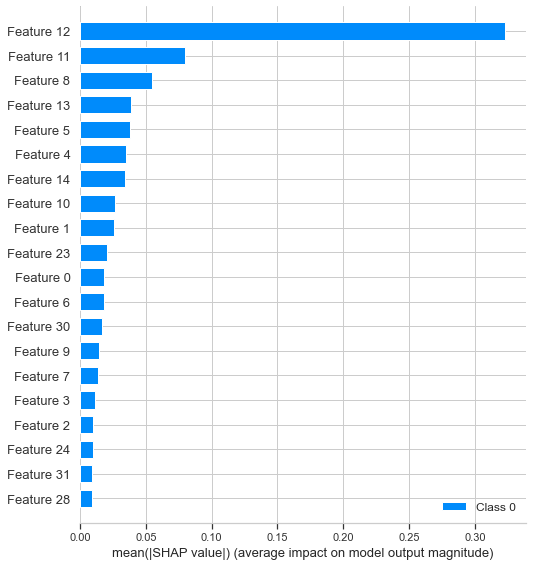

In [27]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [29]:
# and the top 5 important features, while the first one being by far the most important, are the following:

cp.columns[[12,11,8,13,5]]

Index(['Total_Trans_Ct', 'Total_Trans_Amt', 'Total_Revolving_Bal',
       'Total_Ct_Chng_Q4_Q1', 'Months_Inactive_12_mon'],
      dtype='object')

# CONCLUSION FOR THIS PROJECT

The Neural Network with the highest Recall scored (0.96) gives the highest importance to moreless the same features as the LightGBM model, but let's not forget that the LightGBM model's input features have been filtered due to possible multicollinearity. It is possible that if I had removed the features here, too, the performance would have been higher (or lower).

With this notebook I have demonstrated efficient hyperparameter tuning for neural network using Hyperband algorithm built in Keras Tuner. A crucial and valuable knowledge gained through this project is the fact that the tuning can go through with regard to any metric, according to the use/business case and desired goals.

Questions to think about: If I extracted only 6-7 most important features, which correspond within both LightGBM and NN models, would the performance of either of those approaches improve? Does the extra and possibly redundant information for every customer bring in an unwanted bias, considering the fact, that the above-mentioned features were so significantly more important than the others?